In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 25/06/2019


In [2]:
import lax 
from lax.lichens import sciencerun1
from lax.lichens import sciencerun0
from lax.lichens import postsr1

In [3]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = ['/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'],
         make_minitrees = False)

%matplotlib inline

In [4]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_1_DAQFlash_SR1_S1PL.pkl -> First data sample with Flash and DAQ cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_2_DAQFlash_SR1_S1PL.pkl -> Second data sample with Flash and DAQ cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_3_DAQFlash_SR1_S1PL.pkl -> Thirsd data sample with Flash and DAQ cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/NG_DAQFlash_SR1_S1PL.pkl   -> Neutron Generator data with Flash and DAQ cuts
 

### Opening data

In [5]:
file4 = project_path + 'NG_DAQFlash_SR1_S1PL.pkl'
data = pd.read_pickle(file4)

## Data

CES calculated with z-dependent: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:g1g2resfordec#energy_calibration_with_z-dependence_using_the_doke_method
- g1 = (0.1432 +/- 0.0004) + (0.000049 +/- 0.000007)*z
- g2 = (11.63 +/- 0.10) + (0.009 +/- 0.002)*z

In [6]:
W = 13.7 #eV
g1 = 0.1432 + 0.000049*data['z_3d_nn_tf']
g2 = 11.63  + 0.009*data['z_3d_nn_tf']

data['CES'] = W*((data['cs1_nn_tf']/g1) + (data['cs2_bottom_nn_tf']/g2) )

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


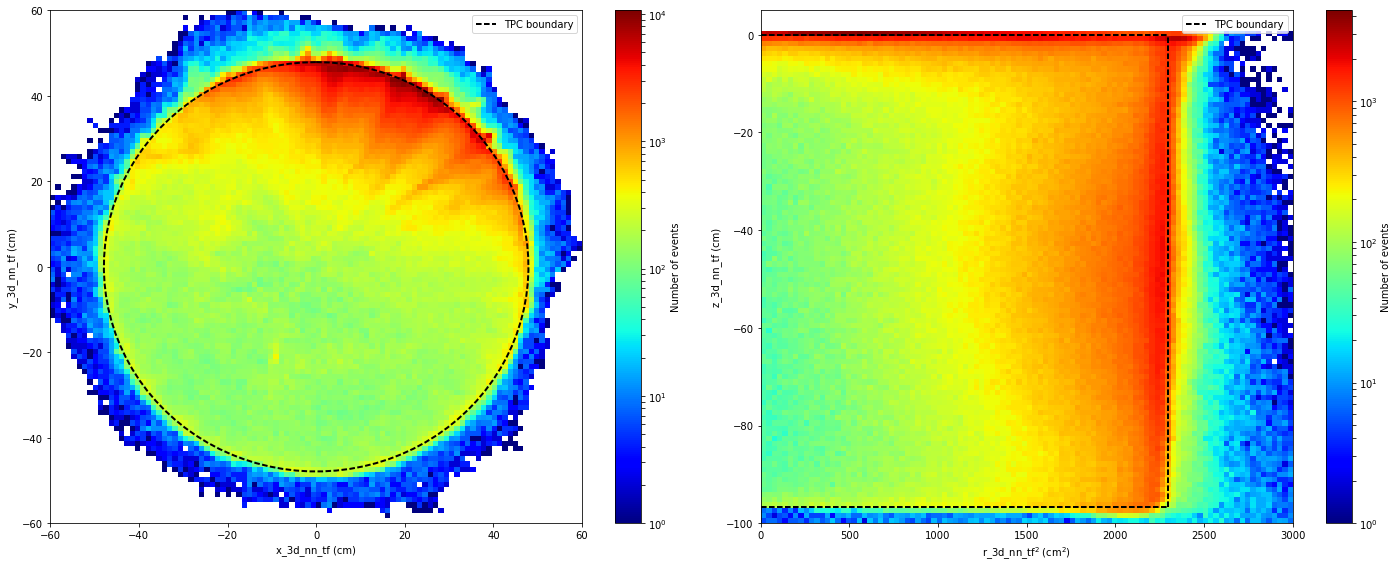

In [7]:
data_distribution(data, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

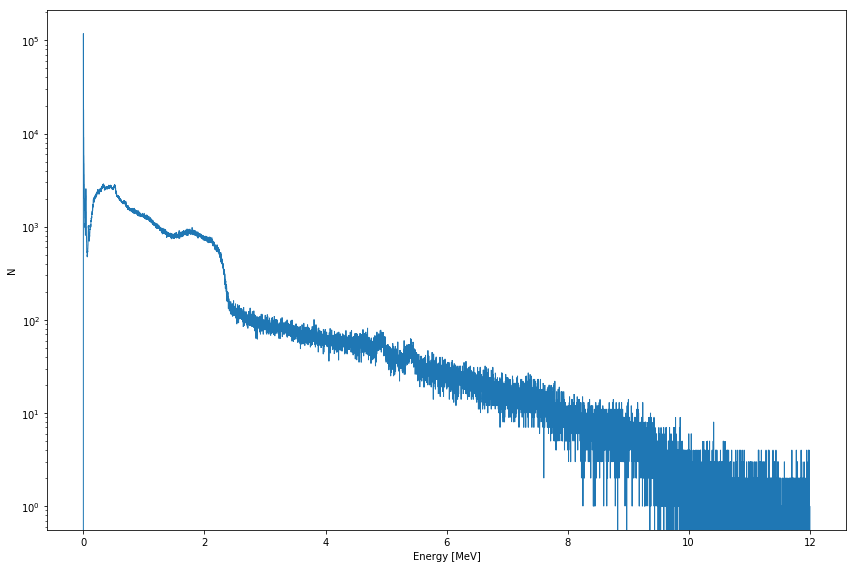

In [8]:
plt.figure(figsize=(12,8))
plt.hist(data['CES']/10**6, bins = (10000), 
         range=(0, 12), 
         histtype='step')
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.tight_layout()
plt.show()

## Selection

- Z in [-83.45, -13.45] cm and r < 39.85 cm for fiducialization
- s1_pattern_fit =! NaN
- S2 =! NaN
- CS2AFT_Extended
- CutS2Threshold 
- CutInteractionsPeaksBiggest
- CutS2Width
- CutS2SingleScatterHE

In [9]:
# Tianyu new S2Singlescatter cut
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix=pickle.load(f)

def classify(df):
    df['CutS2SingleScatterHE'] = 0

    mask = df.eval('(largest_other_s2>0) & (s2>0) & (largest_other_s2_pattern_fit>0) \
    ')
    Y = np.concatenate([np.log10(df.loc[mask,['largest_other_s2', 'largest_other_s2_pattern_fit', 's2']]),
                    ],
                   axis=1)
    df.loc[mask,'CutS2SingleScatterHE'] = gmix.predict(Y)
    df.loc[:, 'CutS2SingleScatterHE'] = np.array(df.CutS2SingleScatterHE, bool)
    return df

In [10]:
data['CutFiducialization'] = (data['z_3d_nn_tf'] < -13.45)&(data['z_3d_nn_tf'] > -83.45)&(data['r_3d_nn_tf'] < 39.85)
data = hax.cuts.selection(data, data['CutFiducialization'] == True)

Unnamed selection: 2395051 rows removed (19.07% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [11]:
data = classify(data)
data = hax.cuts.selection(data, data['CutS2SingleScatterHE'] == True)

Unnamed selection: 412050 rows removed (27.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [12]:
CutS2Threshold = sciencerun1.S2Threshold()
data = CutS2Threshold.process(data)
data = hax.cuts.selection(data, data['CutS2Threshold'] == True)

Unnamed selection: 26735 rows removed (82.46% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [13]:
CS2AFT_Extended = postsr1.CS2AreaFractionTopExtended()
data = CS2AFT_Extended.process(data)
data = hax.cuts.selection(data, data['CutCS2AreaFractionTopExtended'] == True)

Unnamed selection: 16479 rows removed (86.89% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [14]:
CutInteractionsPeaksBiggest = sciencerun1.InteractionPeaksBiggest()
data = CutInteractionsPeaksBiggest.process(data)
data = hax.cuts.selection(data, data['CutInteractionPeaksBiggest'] == True)

Unnamed selection: 3386 rows removed (96.90% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [15]:
CutS2Width = sciencerun1.S2Width()
data = CutS2Width.process(data)
data = hax.cuts.selection(data, data['CutS2Width'] == True)

Unnamed selection: 21441 rows removed (79.74% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [16]:
data['CutS1PatternFitExist'] = np.isnan(data['s1_pattern_fit'])
data['CutCS2bExist'] = np.isnan(data['cs2_bottom_nn_tf'])
data = hax.cuts.selection(data, data['CutS1PatternFitExist'] == False)
data = hax.cuts.selection(data, data['CutCS2bExist'] == False)

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 0 rows removed (100.00% passed)


In [17]:
data.columns

Index(['alt_s1_interaction_drift_time', 'alt_s1_interaction_z',
       'alt_s1_tight_coincidence', 'alt_s2_interaction_s2_range_50p_area',
       'alt_s2_interaction_s2_range_80p_area', 'alt_s2_interaction_x',
       'alt_s2_interaction_y', 'alt_s2_interaction_z', 'cs1', 'cs1_nn',
       ...
       'CutFiducialization', 'CutS2SingleScatterHE', 'CutS2Threshold', 'cxys2',
       'cs2_aft', 'CutCS2AreaFractionTopExtended',
       'CutInteractionPeaksBiggest', 'CutS2Width', 'CutS1PatternFitExist',
       'CutCS2bExist'],
      dtype='object', length=186)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


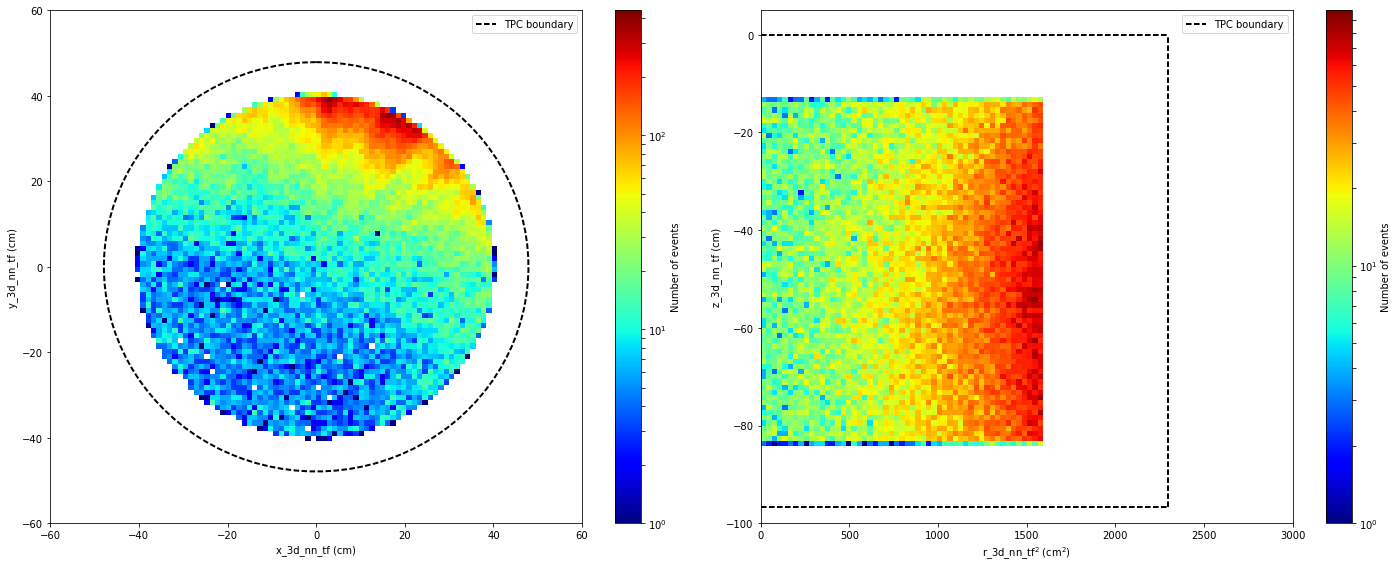

In [18]:
data_distribution(data, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

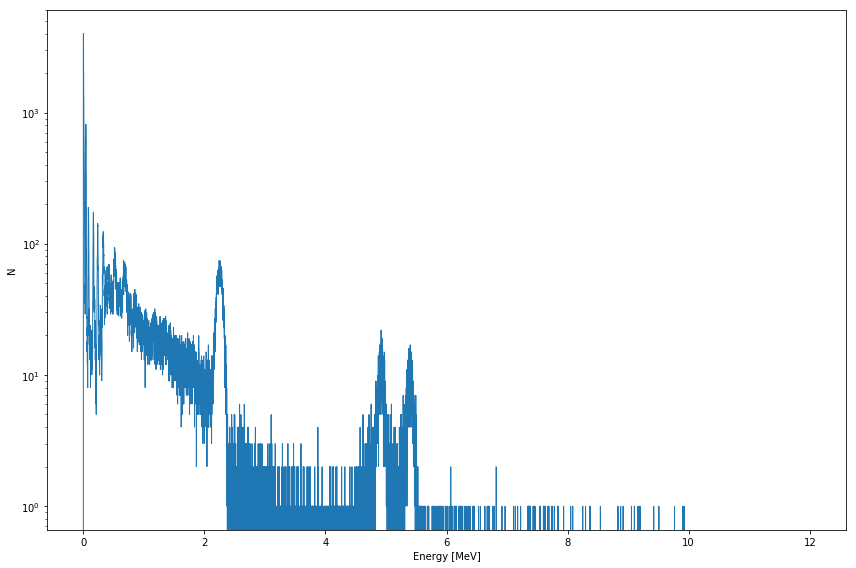

In [19]:
plt.figure(figsize=(12,8))
plt.hist(data['CES']/10**6, bins = (10000), 
         range=(0, 12), 
         histtype='step')
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.tight_layout()
plt.show()

- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_1_cut_SR1_S1PL.pkl -> First data sample after pre-selection cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_2_cut_SR1_S1PL.pkl -> Second data sample after pre-selection cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_3_cut_SR1_S1PL.pkl -> Third data sample after pre-selection cuts
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/NG_cut_SR1_S1PL.pkl   -> Neutron Generator data after pre-selection cuts

In [20]:
#data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_1_cut_SR1_S1PL.pkl')
#data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_2_cut_SR1_S1PL.pkl')
#data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_3_cut_SR1_S1PL.pkl')
data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/NG_cut_SR1_S1PL.pkl')